In [1]:
!pip install scipy --upgrade

     |████████████████████████████████| 27.4MB 152kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import pymc3 as pm
import numpy as np
from scipy.stats import ttest_ind

In [3]:
np.random.seed(0)
conversions1 = np.random.binomial(1, 0.01, size=5400)
conversions2 = np.random.binomial(1, 0.012, size=4600)

In [4]:
# observed conversion rates
print(f'Conversion Rate 1: {conversions1.mean():.1%}')
print(f'Conversion Rate 2: {conversions2.mean():.1%}')

Conversion Rate 1: 0.9%
Conversion Rate 2: 1.1%


In [5]:
print(f'P-Value: {ttest_ind(conversions1, conversions2, equal_var=False, alternative="less").pvalue:.1%}')

P-Value: 11.5%


In [6]:
# Bayesian method
with pm.Model():
  # priors
  rate1 = pm.Beta('rate1', 1, 99)
  rate2 = pm.Beta('rate2', 1, 99)

  # model
  obs1 = pm.Bernoulli('obs1', rate1, observed=conversions1)
  obs2 = pm.Bernoulli('obs2', rate2, observed=conversions2)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate2, rate1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


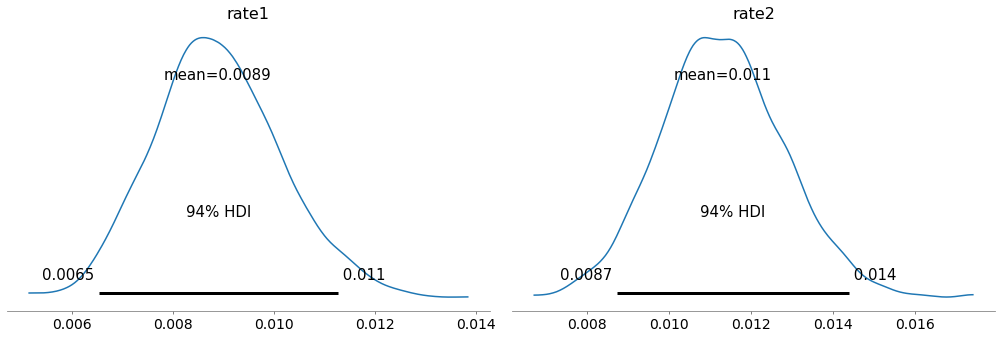

In [7]:
import arviz as az

az.plot_posterior(trace);

In [8]:
conversion1_samples = trace.posterior['rate1'].values
conversion2_samples = trace.posterior['rate2'].values

print(f'Probability that 2 is better than 1: {(conversion2_samples > conversion1_samples).mean():.1%}')

Probability that 2 is better than 1: 88.1%


# Real data time

In [9]:
import pandas as pd

In [10]:
data = pd.read_csv('Training_set_advance.csv')
data

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,16201,47,8433,DX2,60,21.655523,NO,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
1,9421,3,2972,DX6,2,28.852743,NO,RURAL,Stable,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0
2,16205,7,8608,Dx6,20,26.179725,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1
3,5582,31,10074,dx6,8,22.638945,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
4,20880,43,7462,dx1,53,21.326131,NO,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25074,3233,2,2491,Dx3 dx4,33,20.825297,NO,RURAL,Stable,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1
25075,31394,21,2806,DX2,60,22.679810,YES,RURAL,Stable,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0
25076,28315,18,11733,DX4 DX5,51,19.952023,YES,RURAL,Stable,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
25077,1338,4,8577,dx5,21,20.681303,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [11]:
# pretend everything else is randomized enough. We only want to test survival of urban vs. rural patients
use_data = data[['Patient_Rural_Urban', 'Survived_1_year']].copy()
use_data['Patient_Rural_Urban'].unique()

array(['URBAN', 'RURAL'], dtype=object)

In [12]:
use_data['urban'] = 0
use_data.loc[use_data['Patient_Rural_Urban']=='URBAN', 'urban'] = 1
use_data.head()

,Patient_Rural_Urban,Survived_1_year,urban
0,URBAN,1,1
1,RURAL,0,0
2,RURAL,1,0
3,RURAL,0,0
4,RURAL,1,0


In [13]:
urban = use_data.loc[use_data['urban'] == 1, 'Survived_1_year'].values
rural = use_data.loc[use_data['urban'] == 0, 'Survived_1_year'].values

In [14]:
# mean values
print(f'Urban Survival Rate: {np.mean(urban):.1%}')
print(f'Rural Survival Rate: {np.mean(rural):.1%}')

Urban Survival Rate: 54.7%
Rural Survival Rate: 67.2%


In [15]:
# traditional method
print(f'P-Value: {ttest_ind(urban, rural, equal_var=False).pvalue:.5%}')

P-Value: 0.00000%


In [16]:
# Bayesian method
with pm.Model():
  # prior
  urban_rate = pm.Beta('urban_rate', 5, 5)
  rural_rate = pm.Beta('rural_rate', 5, 5)

  # model
  urban_obs = pm.Bernoulli('urban_obs', urban_rate, observed=urban)
  rural_obs = pm.Bernoulli('rural_obs', rural_rate, observed=rural)

  # sample
  trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rural_rate, urban_rate]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


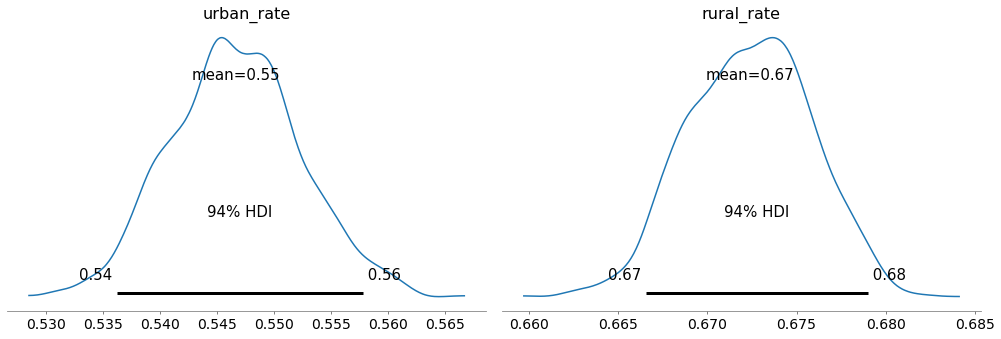

In [17]:
az.plot_posterior(trace);

In [18]:
urban_samples = trace.posterior['urban_rate'].values
rural_samples = trace.posterior['rural_rate'].values

print(f'Probability that Rural Patients survive at a higher rate than Urban Patients: {(rural_samples > urban_samples).mean():.5%}')

Probability that Rural Patients survive at a higher rate than Urban Patients: 100.00000%


## Attempt with Multiple Factors

We are going to use MCMC sampling (from PyMC3) for a linear regression. Yes, the dependent variable is binary and yes it makes sense to use logistic regression instead of linear...but we are going to do linear first.

In [19]:
mult_data = data[['Patient_Smoker', 'Patient_Rural_Urban', 'Survived_1_year']].copy()
mult_data['Patient_Smoker'].unique()

array(['NO', 'NO ', 'YES', 'YES ', 'YESS ', 'YESS', 'Cannot say ',
       'Cannot say', 'CANNOT SAY ', 'CANNOT SAY'], dtype=object)

In [20]:
mult_data.loc[mult_data['Patient_Smoker'] == 'NO ', 'Patient_Smoker'] = 'NO'
mult_data.loc[mult_data['Patient_Smoker'] == 'YES ', 'Patient_Smoker'] = 'YES'
mult_data.loc[mult_data['Patient_Smoker'] == 'YESS ', 'Patient_Smoker'] = 'YES'
mult_data.loc[mult_data['Patient_Smoker'] == 'YESS', 'Patient_Smoker'] = 'YES'
mult_data = mult_data[(mult_data['Patient_Smoker'] == 'NO') | (mult_data['Patient_Smoker'] == 'YES')]

mult_data['smoker'] = [0 if i == 'NO'  else 1 for i in mult_data['Patient_Smoker']]
mult_data['urban'] = [0 if i == 'RURAL' else 1 for i in mult_data['Patient_Rural_Urban']]


mult_data['urban_smoker'] = mult_data['smoker'] * mult_data['urban']

mult_data['urban_nonsmoker'] = 0
mult_data.loc[(mult_data['smoker'] == 0) & (mult_data['urban'] == 1), 'urban_nonsmoker'] = 1

mult_data['rural_smoker'] = 0
mult_data.loc[(mult_data['smoker'] == 1) & (mult_data['urban'] == 0), 'rural_smoker'] = 1

mult_data.head()

,Patient_Smoker,Patient_Rural_Urban,Survived_1_year,smoker,urban,urban_smoker,urban_nonsmoker,rural_smoker
0,NO,URBAN,1,0,1,0,1,0
1,NO,RURAL,0,0,0,0,0,0
2,NO,RURAL,1,0,0,0,0,0
3,NO,RURAL,0,0,0,0,0,0
4,NO,RURAL,1,0,0,0,0,0


In [21]:
urban_smoker = mult_data['urban_smoker'].values
urban_nonsmoker = mult_data['urban_nonsmoker'].values
rural_smoker = mult_data['rural_smoker'].values
survived = mult_data['Survived_1_year'].values

$$\hat{y} = \alpha + \beta_1 \times (urban\: smoker) + \beta_2 \times (urban\: nonsmoker) + \beta_3 \times (rural\: smoker) + \epsilon$$

In [22]:
with pm.Model():
  # priors
  alpha = pm.Normal('alpha', 0, 1)
  beta1 = pm.Normal('beta1', 0, 1)
  beta2 = pm.Normal('beta2', 0, 1)
  beta3 = pm.Normal('beta3', 0, 1)
  sigma = pm.HalfNormal("sigma", 1)


  # model
  mu = alpha + beta1*urban_smoker + beta2*urban_nonsmoker + beta3*rural_smoker
  y = pm.Normal("y", mu, sigma, observed=survived)

  # sample
  trace = pm.sample(return_inferencedata=True) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.


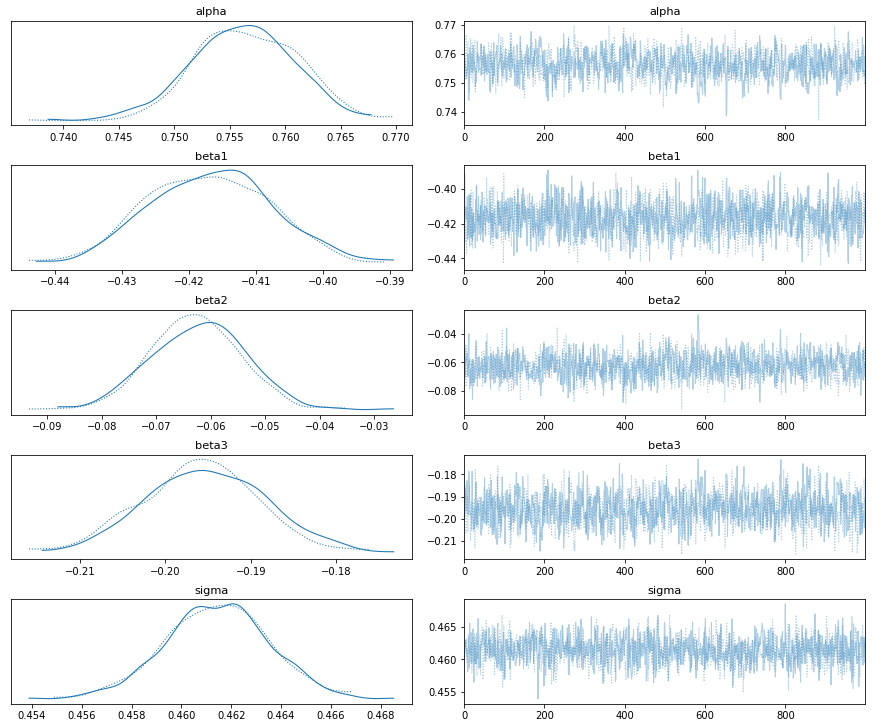

In [23]:
az.plot_trace(trace);

In [24]:
display(az.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.7563,0.0046,0.7487,0.7654,0.0002,0.0001,758.2179,1085.3700,1.0096
beta1,-0.4169,0.0094,-0.4335,-0.3992,0.0003,0.0002,1215.8748,1470.6999,1.0046
beta2,-0.0625,0.0084,-0.0769,-0.0458,0.0003,0.0002,893.4575,1464.2457,1.0061
beta3,-0.1956,0.0071,-0.2094,-0.1824,0.0002,0.0002,883.8846,1457.1269,1.0085
sigma,0.4614,0.0021,0.4576,0.4654,0.0000,0.0000,1699.8578,1507.3118,1.0032


In [25]:
beta1_samples = trace.posterior['beta1'].values
beta2_samples = trace.posterior['beta2'].values
beta3_samples = trace.posterior['beta3'].values


print('Probability that each coefficient is positive:') 
print(f'Urban Smoker: {(beta1_samples >= 0).mean():.5%}')
print(f'Urban NonSmoker: {(beta2_samples >= 0).mean():.5%}')
print(f'Rural Smoker: {(beta3_samples >= 0).mean():.5%}')


Probability that each coefficient is positive:
Urban Smoker: 0.00000%
Urban NonSmoker: 0.00000%
Rural Smoker: 0.00000%


In [26]:
# using a formula
with pm.Model() as model:

    pm.glm.GLM.from_formula("Survived_1_year ~ smoker + urban + smoker:urban", mult_data)
    
    trace = pm.sample(4000, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, smoker:urban, urban, smoker, Intercept]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 74 seconds.


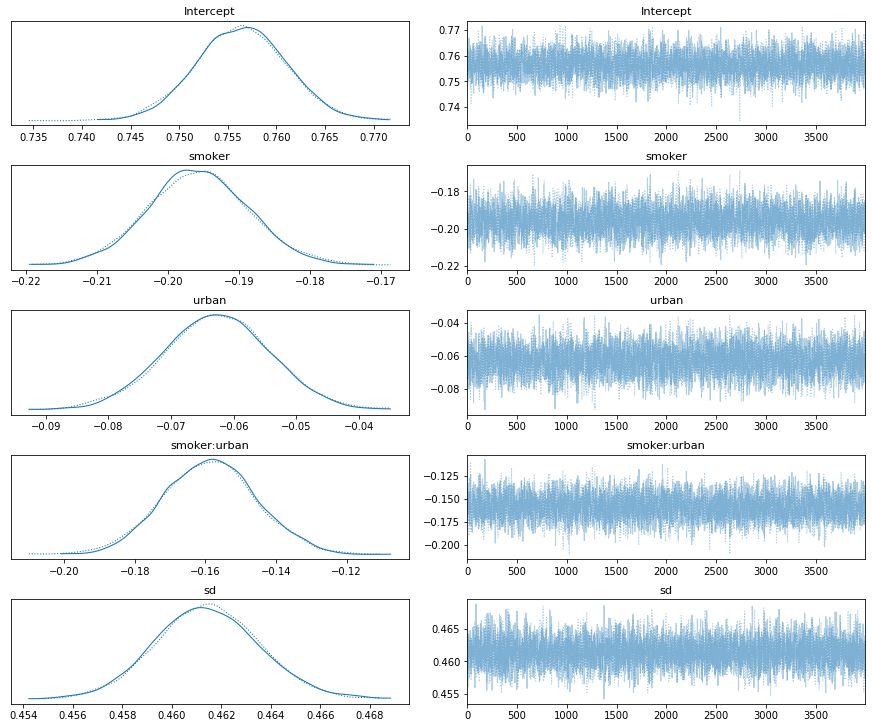

In [27]:
az.plot_trace(trace);

In [28]:
display(az.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.7564,0.0046,0.7477,0.7650,0.0001,0.0000,4653.6509,5026.4501,1.0005
smoker,-0.1957,0.0071,-0.2094,-0.1823,0.0001,0.0001,4789.0209,5084.9444,1.0002
urban,-0.0627,0.0085,-0.0786,-0.0465,0.0001,0.0001,4831.4614,4874.0154,1.0003
smoker:urban,-0.1587,0.0132,-0.1822,-0.1326,0.0002,0.0001,5079.3030,5184.4169,1.0007
sd,0.4614,0.0021,0.4576,0.4655,0.0000,0.0000,7114.5936,4655.5687,1.0005


In [29]:
# traditional
import statsmodels.api as sm
from statsmodels.formula.api import ols

trad_lm = ols('Survived_1_year ~ smoker + urban + smoker*urban', data=mult_data).fit()
trad_anova = sm.stats.anova_lm(trad_lm)
trad_lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Survived_1_year   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     749.7
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:56:20   Log-Likelihood:                -16182.
No. Observations:               25071   AIC:                         3.237e+04
Df Residuals:                   25067   BIC:                         3.240e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7565      0.005    163.581      0.000       0.747       0.766
smoker          -0.1957      0.007    -27.760      0.000      -0.210      -0.182
urban           -0.0629      0.008     -7.552      0.000      -0.079      -0.047
smoker:urban    -0.1584      0.013    -12.325      0.000      -0.184      -0.133
==============================================================================
Omnibus:                   544478.176   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3069.599
Skew:                          -0.530   Prob(JB):                         0.00
Kurtosis:                       1.652   Cond. No.                         6.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
trad_anova

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,358.007644,358.007644,1681.388006,0.000000e+00
urban,1.0,88.522615,88.522615,415.747724,1.140413e-91
smoker:urban,1.0,32.344939,32.344939,151.908466,8.369280e-35
Residual,25067.0,5337.362687,0.212924,NaN,NaN


## Logistic Multiple Regression

In [31]:
# The easy way
with pm.Model() as model:

    pm.glm.GLM.from_formula("Survived_1_year ~ smoker + urban + smoker:urban", mult_data, family='binomial')
    
    trace = pm.sample(4000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [smoker:urban, urban, smoker, Intercept]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 426 seconds.
The acceptance probability does not match the target. It is 0.8829077170276756, but should be close to 0.8. Try to increase the number of tuning steps.


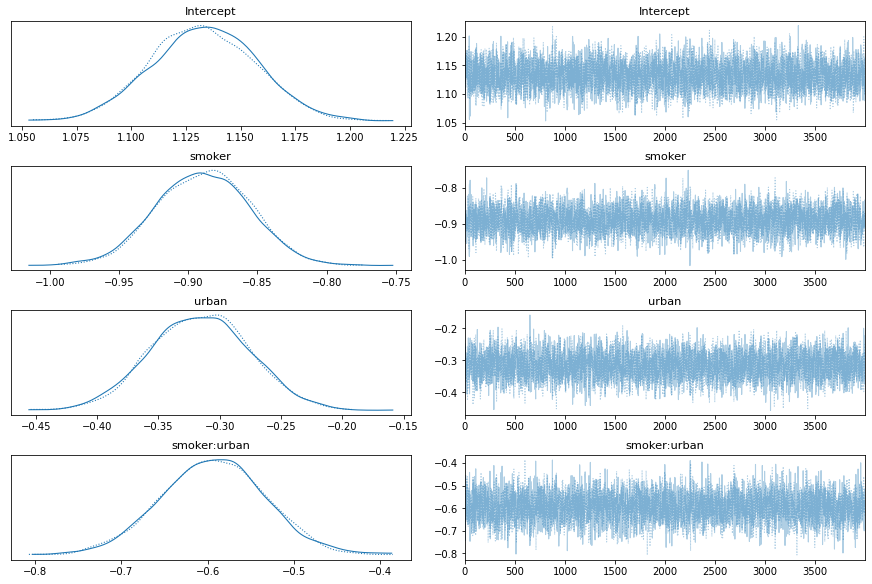

In [32]:
az.plot_trace(trace);

In [33]:
display(az.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.1330,0.0238,1.0901,1.1790,0.0004,0.0003,3659.5529,4423.2479,1.0004
smoker,-0.8892,0.0335,-0.9479,-0.8240,0.0006,0.0004,3376.6646,4554.5465,1.0003
urban,-0.3157,0.0402,-0.3890,-0.2390,0.0007,0.0005,3500.6098,4871.6701,0.9998
smoker:urban,-0.5934,0.0604,-0.7083,-0.4816,0.0010,0.0007,3414.3954,4869.7503,1.0001


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 864x576 with 0 Axes>

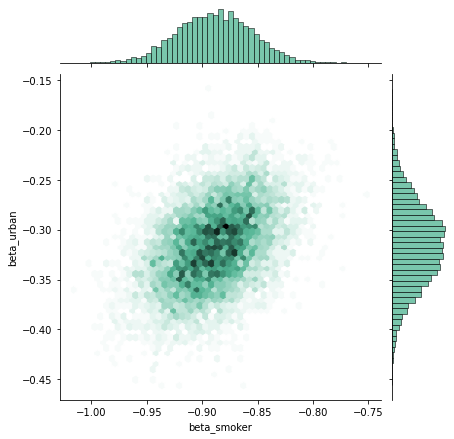

In [35]:
smoker_post = np.concatenate([trace.posterior['smoker'][0].values, trace.posterior['smoker'][1].values])
urban_post = np.concatenate([trace.posterior['urban'][0].values, trace.posterior['urban'][1].values])

plt.figure(figsize=(12, 8))
sns.jointplot(x = smoker_post, y = urban_post, kind="hex", color="#4CB391")
plt.xlabel("beta_smoker")
plt.ylabel("beta_urban");

In [36]:
intercept = np.concatenate([trace.posterior['Intercept'][0].values, trace.posterior['Intercept'][1].values])
smoker_urban_post = np.concatenate([trace.posterior['smoker:urban'][0].values, trace.posterior['smoker:urban'][1].values])

smoker = mult_data['smoker'].values
urban = mult_data['urban'].values

In [37]:
sample = np.random.choice(range(len(intercept)), size=100)
means = [intercept[i] + smoker*smoker_post[i] + urban*urban_post[i] + smoker*urban*smoker_urban_post[i] for i in sample]
probs = [1 / (1+np.exp(-i)) for i in means]
all_probs = probs[0]
for i in range(1, len(probs)):
  all_probs = np.concatenate([all_probs, probs[i]])

In [38]:
smoker_plot = np.resize(smoker, all_probs.shape[0])
urban_plot = np.resize(urban, all_probs.shape[0])

In [89]:
scatter_sample = np.random.choice(range(len(all_probs)), size=100000)
scatter_smoker = smoker_plot[sample]
scatter_urban = urban_plot[sample]
scatter_probs = all_probs[sample]
scatter = pd.DataFrame([smoker_plot, urban_plot, all_probs])
scatter = scatter.T
scatter.columns = ['Urban', 'Smoker', 'Probability']

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


,Urban,Smoker,Probability,urban_smoker
0,0.0,1.0,0.699801,Rural Non-Smoker
1,0.0,0.0,0.758843,Rural Non-Smoker
2,0.0,0.0,0.758843,Rural Non-Smoker
3,0.0,0.0,0.758843,Rural Non-Smoker
4,0.0,0.0,0.758843,Rural Non-Smoker
...,...,...,...,...
2507095,0.0,0.0,0.755187,Rural Non-Smoker
2507096,1.0,0.0,0.558887,Rural Non-Smoker
2507097,1.0,0.0,0.558887,Rural Non-Smoker
2507098,0.0,1.0,0.680986,Rural Non-Smoker


In [94]:
scatter['Patient Type'] = 'Rural Non-Smoker'
scatter.loc[(scatter['Urban'] == 1) & (scatter['Smoker'] == 0), 'Patient Type'] = 'Urban Non-Smoker'
scatter.loc[(scatter['Urban'] == 0) & (scatter['Smoker'] == 1), 'Patient Type'] = 'Rural Smoker'
scatter.loc[(scatter['Urban'] == 1) & (scatter['Smoker'] == 1), 'Patient Type'] = 'Urban Smoker'

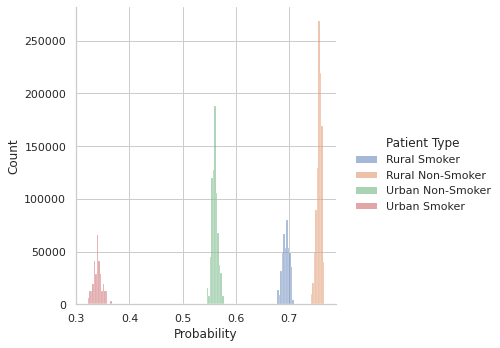

In [97]:
sns.set_style('whitegrid')
sns.displot(data=scatter, x='Probability', hue='Patient Type');